# Qwen3 Tuning
for ARC AGI 2

Updates 29 July 2025:
- Now using utils from the repo.
- Updated lora r to 128, down from 256 as prob 128 is sufficient.

Updates 24 July 2025:
- Now supports calculation of metrics BUT requires validation data have code. This will be updated later to just pass grids for validation.

Updates 23 July 2025:
- Back to constant scheduler for one epoch. Note that SOAR use 3 epochs with cosine scheduler.

Updates 22 July 2025:
- Increased lora r to 256
- Added training on completions only
- Moved to cosine rather than constant scheduler. Moved from 1 to 2 epochs. Note that SOAR use 3 epochs with cosine scheduler.

In [1]:
# !git pull

In [2]:
# !git config --global user.name “RonanMcGovern”
# !git config --global user.email "78278410+RonanKMcGovern@users.noreply.github.com"

In [3]:
import os
os.environ["HF_HOME"] = "/workspace"
os.environ["HF_HUB_CACHE"] = "/workspace/hub" # (recommended) override just the repo cache
print(os.environ["HF_HOME"])

/workspace


### Installation

In [4]:
#To run with vllm.
!uv pip install vllm --system -qU

In [5]:
# Temporary Fix while unsloth is broken! - SHOULD BE FIXED AS OF JULY 20TH 2025
!rm -rf /tmp/unsloth_compiled_cache
!uv pip uninstall trl unsloth --system -q
!uv pip install unsloth -qU --system
!uv pip install trl==0.19.1 --system -q

# sometimes unsloth throws numpy issues
!uv pip uninstall numpy --system -q
!uv pip install numpy==2.2 --system -q
!uv pip show numpy -q

In [6]:
# INSTALLED IN THE CONTAINER IF USING the [arc-agi-2025 container on runpod](https://console.runpod.io/deploy?template=bh0rvngapk&ref=jmfkcdio)
# %%capture
# import os
# !pip install uv -qU
# !uv pip install unsloth matplotlib tensorboard -qU --system
# !export HF_HUB_ENABLE_HF_TRANSFER=1

In [7]:
# # # if you face model download issues
# import os
# os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"

In [8]:
from huggingface_hub import HfFolder, login

# Call this at the top of your script / notebook
if HfFolder.get_token() is None:   # no token cached or in $HF_TOKEN
    login()                        # interactive prompt

In [9]:
%load_ext tensorboard
%tensorboard --logdir ./logs --port 6006 --bind_all

### Unsloth

In [10]:
# !uv pip show trl unsloth vllm transformers

In [11]:
!nvidia-smi

Thu Jul 31 14:03:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H200                    On  |   00000000:3A:00.0 Off |                    0 |
| N/A   29C    P0             75W /  700W |       1MiB / 143771MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [12]:
import os
import unsloth
from unsloth import FastLanguageModel
import torch

# model_slug = "Qwen/Qwen3-4B"
model_slug = "julien31/Soar-qwen-7b"
# model_slug = "Qwen/Qwen2.5-Coder-7B-Instruct"
# model_slug = "Qwen/Qwen3-30B-A3B"

model_max_length = 32768 #default is ~2k for unsloth!!!
lora_rank = 128

# Training AND validation batch size (incl. for autoregressive train/test example metrics calculations)
batch_size_global = 2 # use 2 for 7/8B, use 4 for 4B on H200.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_slug,
    max_seq_length = model_max_length,   # Context length - can be longer, but uses more memory
    load_in_4bit = False,     # 4bit uses much less memory
    load_in_8bit = False,    # A bit more accurate, uses 2x memory
    full_finetuning = False, # We have full finetuning now!
    # cache_dir = '/workspace',
    # token = "hf_...",      # use one if using gated models
    
    # for using fast_inference
    fast_inference = True, # allows for vLLM generation during evaluation
    max_lora_rank=lora_rank,
    gpu_memory_utilization=0.3,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 07-31 14:03:36 [__init__.py:235] Automatically detected platform cuda.
Unsloth: Patching vLLM v1 graph capture
Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2025.7.11: Fast Qwen2 patching. Transformers: 4.54.1. vLLM: 0.10.0.
   \\   /|    NVIDIA H200. Num GPUs = 1. Max memory: 139.719 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 9.0. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading julien31/Soar-qwen-7b with actual GPU utilization = 29.87%
Unsloth: Your GPU has CUDA compute capability 9.0 with VRAM = 139.72 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 32768. Num Seq

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 07-31 14:03:51 [default_loader.py:262] Loading weights took 3.44 seconds
INFO 07-31 14:03:51 [punica_selector.py:19] Using PunicaWrapperGPU.
INFO 07-31 14:03:51 [gpu_model_runner.py:1892] Model loading took 14.9651 GiB and 3.821152 seconds
INFO 07-31 14:04:04 [backends.py:530] Using cache directory: /root/.cache/vllm/torch_compile_cache/4d5df2c9da/rank_0_0/backbone for vLLM's torch.compile
INFO 07-31 14:04:04 [backends.py:541] Dynamo bytecode transform time: 8.21 s
INFO 07-31 14:04:10 [backends.py:161] Directly load the compiled graph(s) for dynamic shape from the cache, took 5.555 s
INFO 07-31 14:04:31 [monitor.py:34] torch.compile takes 8.21 s in total
INFO 07-31 14:04:33 [gpu_worker.py:255] Available KV cache memory: 22.07 GiB
INFO 07-31 14:04:33 [kv_cache_utils.py:833] GPU KV cache size: 413,296 tokens
INFO 07-31 14:04:33 [kv_cache_utils.py:837] Maximum concurrency for 32,768 tokens per request: 12.61x
INFO 07-31 14:04:34 [vllm_utils.py:641] Unsloth: Running patched vLLM v1 `c

Capturing CUDA graph shapes: 100%|██████████| 67/67 [00:28<00:00,  2.36it/s]

INFO 07-31 14:05:02 [gpu_model_runner.py:2485] Graph capturing finished in 28 secs, took 0.82 GiB
INFO 07-31 14:05:02 [vllm_utils.py:648] Unsloth: Patched vLLM v1 graph capture finished in 28 secs.


INFO 07-31 14:05:03 [core.py:193] init engine (profile, create kv cache, warmup model) took 71.46 seconds
Unsloth: Just some info: will skip parsing ['pre_feedforward_layernorm', 'post_feedforward_layernorm', 'k_norm', 'q_norm']
Unsloth: Just some info: will skip parsing ['pre_feedforward_layernorm', 'post_feedforward_layernorm', 'k_norm', 'q_norm']


In [13]:
!nvidia-smi

Thu Jul 31 14:05:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H200                    On  |   00000000:3A:00.0 Off |                    0 |
| N/A   32C    P0            117W /  700W |   40088MiB / 143771MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
print(model.max_seq_length)

32768


In [15]:
# # Print a summary of the transformer layers and key dimensions
# for i, block in enumerate(model.model.layers):
#     attn = block.self_attn
#     mlp = block.mlp

#     print(f"Layer {i}:")
#     print(f"  Attention:")
#     print(f"    q_proj: {attn.q_proj.weight.shape}")
#     print(f"    k_proj: {attn.k_proj.weight.shape}")
#     print(f"    v_proj: {attn.v_proj.weight.shape}")
#     print(f"    out_proj: {attn.o_proj.weight.shape}")
#     print(f"  MLP:")
#     print(f"    fc1: {mlp.gate_proj.weight.shape}")
#     print(f"    fc2: {mlp.up_proj.weight.shape}")
#     print(f"    fc3: {mlp.down_proj.weight.shape}")
#     print()

In [16]:
# print(model)

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [17]:
model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank,           # Choose any number > 0! Suggested 8, 16, 32, 64, 128. could consider 128.
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",
                     ],
    lora_alpha = 64,  # Best to choose alpha = rank or rank*2. EXCEPT if using rslora, in which case set it as sqrt(max matrix dimension). 64 is good for Qwen 4B
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = True,   # We support rank stabilized LoRA
    loftq_config = None,  # And LoftQ
)

Unsloth 2025.7.11 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [18]:
print(tokenizer.padding_side)

right


In [19]:
# Import utils using standard project root detection
from pathlib import Path
import sys

# Find project root by looking for pyproject.toml
project_root = next(
    (parent for parent in [Path.cwd()] + list(Path.cwd().parents) 
     if (parent / "pyproject.toml").exists()), 
    Path.cwd()
)

# Add llm_python directory to path (where utils is located)
llm_python_dir = project_root / "llm_python"
sys.path.insert(0, str(llm_python_dir))

print(f"📁 Project root: {project_root}")
print(f"📁 Looking for utils in: {llm_python_dir}")

from utils.task_loader import TaskLoader
from utils.scoring import GridScorer, ProgramExecutor
from utils.prompt_utils import create_arc_prompt, extract_python_code
from utils.metrics_utils import calculate_task_metrics, format_metrics_display, metrics_to_percentages
from utils.timeout_utils import execute_with_timeout
from utils.transduction import is_transduction_cheating
from utils.prompt_loader import PromptLoader

# Initialize utility instances
prompt_loader = PromptLoader()
scorer = GridScorer()
print("✅ Utils imported and initialized successfully")

📁 Project root: /workspace/arc-agi-2025
📁 Looking for utils in: /workspace/arc-agi-2025/llm_python
✅ Utils imported and initialized successfully


<a name="Data"></a>
### Data Prep

In [20]:
from pathlib import Path
import json
from typing import Optional
from datasets import load_dataset, DatasetDict

# ---------------------------------------------------------------------
# Config (examples)
# ---------------------------------------------------------------------

# Set max_rows flag to limit train size. None for all
max_rows = 32 # None for all rows
max_validation_rows = 8

# # CASE 1: single slug with both splits
# train_slug = "Trelis/synth_arc-agi-1_all_training_20250724_131808"
# val_slug = None

# CASE 2: two different slugs
train_slug = "Trelis/soar-20250729_114431-1600"
val_slug   = "Trelis/grids_only_arc-agi-1_all_evaluation_20250729_102313"

enable_thinking = False  # See note in original code

# ---------------------------------------------------------------------
# Prompt management using utils (replacing hard-coded prompts)
# ---------------------------------------------------------------------

# Use prompt_loader to get SOAR prompts from utils
SYSTEM_PROMPT = prompt_loader.get_system_message("soar")
INITIAL_TURN_PROMPT = prompt_loader.get_initial_turn_prompt("soar")

print(f"✅ Using SOAR prompts from utils:")
print(f"   System prompt: {len(SYSTEM_PROMPT)} chars")
print(f"   Initial turn prompt: {len(INITIAL_TURN_PROMPT)} chars")

# Custom formatting functions removed - using create_arc_prompt from utils instead

def hf_dataset_to_chat_dataset(dataset_slug: str, split: str = "train"):
    """
    Convert a HF split into the chat/prompt format using utils.
    """
    ds = load_dataset(dataset_slug, split=split, keep_in_memory=True)

    def select_output(example, output_key, predicted_key):
        """
        Select between regular output and predicted output based on availability and non-zero values.
        """
        # Check if predicted output exists and is non-zero
        if predicted_key in example and example[predicted_key]:
            predicted = example[predicted_key]
            # Check if any predicted output is non-zero (has any non-zero cells)
            if any(any(any(cell != 0 for cell in row) for row in grid) for grid in predicted):
                return predicted
        
        # Fall back to regular output
        return example[output_key]

    def create_chat_messages(example):
        # Select appropriate outputs (predicted if available and non-zero, otherwise regular)
        train_outputs = select_output(example, "train_output", "predicted_train_output")
        test_outputs = select_output(example, "test_output", "predicted_test_output")
        
        # Create task_data in the format expected by create_arc_prompt
        task_data = {
            'train': [{'input': inp, 'output': out} 
                     for inp, out in zip(example["train_input"], train_outputs)],
            'test': [{'input': inp, 'output': out} 
                     for inp, out in zip(example["test_input"], test_outputs)]  # All test examples!
        }
        
        # Use create_arc_prompt from utils (matches run_arc_tasks_soar.py)
        system_content, user_content = create_arc_prompt(task_data, prompt_loader, "soar")

        assistant_content = ""
        if enable_thinking and example.get("reasoning", "").strip():
            assistant_content += f"<think>{example['reasoning'].strip()}</think>"
        assistant_content += f"```python\n{example['code']}\n```"

        messages = [
            {"role": "system", "content": system_content},
            {"role": "user",   "content": user_content},
            {"role": "assistant", "content": assistant_content},
        ]

        prompt_messages = [
            {"role": "system", "content": system_content},
            {"role": "user",   "content": user_content},
        ]

        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=False,
            enable_thinking = enable_thinking
        )

        prompt_text = tokenizer.apply_chat_template(
            prompt_messages,
            tokenize=False,
            add_generation_prompt=True,
            enable_thinking = enable_thinking
        )

        return {
            "messages": messages,
            "text": text,
            "prompt": prompt_text,
            "train_input": example["train_input"],
            "train_output": train_outputs,  # Use selected outputs (predicted when available)
            "test_input": example["test_input"],
            "test_output": test_outputs,    # Use selected outputs (predicted when available)
            "reasoning": example.get("reasoning", ""),
            "code": example["code"],
            "task_id": example.get("task_id", ""),
        }

    ds = ds.map(create_chat_messages, desc=f"build chat + prompt fields ({split})")
    return ds

def build_dataset(train_slug: str,
                  val_slug: Optional[str] = None,
                  train_split: str = "train",
                  val_split: str = "validation") -> DatasetDict:
    """
    Build a DatasetDict with 'train' and 'validation' keys.
    - If val_slug is None, both splits are loaded from train_slug.
    - Otherwise, load train_split from train_slug and val_split from val_slug.
    """
    
    # Load and filter
    train_ds = hf_dataset_to_chat_dataset(train_slug, split=train_split)
    if max_rows:
        train_ds = train_ds.select(range(min(len(train_ds), max_rows)))
    
    # Validation logic
    if val_slug is None:
        try:
            val_ds = hf_dataset_to_chat_dataset(train_slug, split=val_split)
        except Exception as e:
            raise ValueError(
                f"Could not load split '{val_split}' from '{train_slug}'. "
                f"Pass an explicit val_slug or choose a valid split.\nOriginal error: {e}"
            )
    else:
        val_ds = hf_dataset_to_chat_dataset(val_slug, split="train")
    
    # Corrected slice
    if max_validation_rows:
        val_ds = val_ds.select(range(min(len(val_ds), max_validation_rows)))
    elif max_rows:
        val_ds = val_ds.select(range(min(len(val_ds), max_rows)))
    
    return DatasetDict(train=train_ds, validation=val_ds)

# ---------------------------------------------------------------------
# Build the dataset
# ---------------------------------------------------------------------
data = build_dataset(train_slug, val_slug)  # val_slug may be None 

✅ Using SOAR prompts from utils:
   System prompt: 129 chars
   Initial turn prompt: 990 chars


README.md:   0%|          | 0.00/915 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/811k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1600 [00:00<?, ? examples/s]

build chat + prompt fields (train):   0%|          | 0/1600 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/886 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/219k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

build chat + prompt fields (train):   0%|          | 0/400 [00:00<?, ? examples/s]

In [21]:
# Validation split
val_ids = [ex["task_id"] for ex in data["validation"]]
assert all(val_ids), "❌ some validation rows are missing task_id"
assert len(val_ids) == len(set(val_ids)), "❌ duplicate task_id in validation slice"

In [22]:
# # print(data["train"][0])
# print(data["train"][0]['prompt'])

In [23]:
# print(data["train"][0]['text'])

In [24]:
print(data["validation"][0]['text'])

<|im_start|>system
You are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by reasoning and generating Python code.<|im_end|>
<|im_start|>user
You are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by generating Python code.
Your goal is to analyze input-output grid pairs. The outputs were produced by applying a transformation rule to the inputs. Implement the transformation rules as a Python function.
You should only write the implemented the transformation in code.
You must write code in triple backticks (```python and then ```). You must write a function called 'transform' which takes a single argument, the input grid as 'list[list[int]]', and returns the transformed grid (also as 'list[list[int]]').
You should make sure that you implement a version of the transformation which works in general (at least for all given input-output pairs and test input pairs).
The number in the input grid can be mapped to the following

Let's see the structure of both datasets:

In [25]:
import numpy as np
from statistics import median

def length_stats(dataset, name=""):
    """
    Return min / median / max tokenised length for a 🤗 Dataset split that has a
    single 'text' column. Uses the same tokenizer already in memory.
    """
    # Tokenise in batches → list of list[int] → list[int] lengths
    lengths = dataset.map(
        lambda batch: {
            "len": [len(ids) for ids in tokenizer(batch["text"],
                                                  add_special_tokens=False
                                                 )["input_ids"]]
        },
        batched=True,
        remove_columns=dataset.column_names,   # drop 'text'
        keep_in_memory=True,
    )["len"]

    print(f"{name:>11}:  min={min(lengths):>4}  "
          f"median={int(median(lengths)):>4}  max={max(lengths):>4}")

# ── run for both splits ────────────────────────────────────────────────────────
length_stats(data["train"],       "train")
length_stats(data["validation"],  "validation")


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

      train:  min= 731  median=1760  max=6468


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

 validation:  min= 627  median=4785  max=15047


### Pre-Training Data Integrity Tests
Before training, let's test the ground-truth code on a random sample of training examples to validate dataset quality and establish baseline performance.


In [26]:
import random

# Configuration for pre-training tests
NUM_TEST_EXAMPLES = 100  # Number of random examples to test
RANDOM_SEED = 42  # For reproducible results

def run_pre_training_data_integrity_tests(dataset_split="train", num_examples=NUM_TEST_EXAMPLES):
    """
    Test ground-truth code from dataset on random examples to validate data quality.
    
    Args:
        dataset_split: Which split to test (should be "train" since validation has no ground-truth code)
        num_examples: Number of random examples to test
    """
    print(f"🧪 Running Pre-Training Data Integrity Tests")
    print(f"📊 Testing {num_examples} random examples from {dataset_split} split")
    print("=" * 60)
    
    # Set seed for reproducible sampling
    random.seed(RANDOM_SEED)
    
    # Get the dataset split
    dataset = data[dataset_split]
    
    # Randomly sample examples
    total_examples = len(dataset)
    if num_examples > total_examples:
        print(f"⚠️  Requested {num_examples} examples but only {total_examples} available. Testing all.")
        sample_indices = list(range(total_examples))
    else:
        sample_indices = random.sample(range(total_examples), num_examples)
    
    # Initialize tracking variables
    results = []
    executor = ProgramExecutor(timeout=2.0, executor_type="unrestricted")
    
    print(f"\n🔍 Testing {len(sample_indices)} examples...\n")
    
    for i, idx in enumerate(sample_indices):
        example = dataset[idx]
        task_id = example.get("task_id", f"idx_{idx}")
        code = example["code"]
        
        print(f"[{i+1}/{len(sample_indices)}] Testing {task_id}")
        
        # Initialize results for this example
        example_result = {
            "task_id": task_id,
            "index": idx,
            "code": code,
            "train_results": [],
            "test_results": [],
            "train_success": 0,
            "test_success": 0,
            "code_executed": False,
            "errors": []
        }
        
        # Test on training examples
        train_correct = 0
        for t_idx, (train_in, train_out) in enumerate(zip(example["train_input"], example["train_output"])):
            try:
                predicted_output, error, timed_out = executor.execute_program_with_timeout(code, train_in)
                
                if predicted_output is not None:
                    example_result["code_executed"] = True
                    score_result = scorer.score_grid(predicted_output, train_out)
                    is_correct = score_result["correct"]
                    
                    if is_correct:
                        train_correct += 1
                    
                    example_result["train_results"].append({
                        "index": t_idx,
                        "correct": is_correct,
                        "predicted": predicted_output,
                        "expected": train_out,
                        "timed_out": timed_out
                    })
                else:
                    example_result["train_results"].append({
                        "index": t_idx,
                        "correct": False,
                        "error": error,
                        "timed_out": timed_out
                    })
                    if error:
                        example_result["errors"].append(f"Train {t_idx}: {error}")
                        
            except Exception as e:
                example_result["train_results"].append({
                    "index": t_idx,
                    "correct": False,
                    "error": str(e)
                })
                example_result["errors"].append(f"Train {t_idx}: {str(e)}")
        
        # Test on test examples
        test_correct = 0
        for t_idx, (test_in, test_out) in enumerate(zip(example["test_input"], example["test_output"])):
            try:
                predicted_output, error, timed_out = executor.execute_program_with_timeout(code, test_in)
                
                if predicted_output is not None:
                    example_result["code_executed"] = True
                    score_result = scorer.score_grid(predicted_output, test_out)
                    is_correct = score_result["correct"]
                    
                    if is_correct:
                        test_correct += 1
                    
                    example_result["test_results"].append({
                        "index": t_idx,
                        "correct": is_correct,
                        "predicted": predicted_output,
                        "expected": test_out,
                        "timed_out": timed_out
                    })
                else:
                    example_result["test_results"].append({
                        "index": t_idx,
                        "correct": False,
                        "error": error,
                        "timed_out": timed_out
                    })
                    if error:
                        example_result["errors"].append(f"Test {t_idx}: {error}")
                        
            except Exception as e:
                example_result["test_results"].append({
                    "index": t_idx,
                    "correct": False,
                    "error": str(e)
                })
                example_result["errors"].append(f"Test {t_idx}: {str(e)}")
        
        # Calculate success rates for this example
        example_result["train_success"] = train_correct / len(example["train_input"]) if example["train_input"] else 0
        example_result["test_success"] = test_correct / len(example["test_input"]) if example["test_input"] else 0
        
        # Print summary for this example
        total_train = len(example["train_input"])
        total_test = len(example["test_input"])
        
        print(f"  ✅ Train: {train_correct}/{total_train} ({example_result['train_success']:.1%})")
        print(f"  ✅ Test:  {test_correct}/{total_test} ({example_result['test_success']:.1%})")
        
        if example_result["errors"]:
            print(f"  ❌ Errors: {len(example_result['errors'])}")
        if not example_result["code_executed"]:
            print(f"  ⚠️  Code never executed successfully")
        print()
        
        results.append(example_result)
    
    return results

# Run the tests
data_integrity_results = run_pre_training_data_integrity_tests("train", NUM_TEST_EXAMPLES)

🧪 Running Pre-Training Data Integrity Tests
📊 Testing 100 random examples from train split
⚠️  Requested 100 examples but only 32 available. Testing all.

🔍 Testing 32 examples...

[1/32] Testing 007bbfb7
  ✅ Train: 5/5 (100.0%)
  ✅ Test:  1/1 (100.0%)

[2/32] Testing 007bbfb7
  ✅ Train: 5/5 (100.0%)
  ✅ Test:  1/1 (100.0%)

[3/32] Testing 007bbfb7
  ✅ Train: 5/5 (100.0%)
  ✅ Test:  1/1 (100.0%)

[4/32] Testing 007bbfb7
  ✅ Train: 5/5 (100.0%)
  ✅ Test:  1/1 (100.0%)

[5/32] Testing 0520fde7
  ✅ Train: 3/3 (100.0%)
  ✅ Test:  1/1 (100.0%)

[6/32] Testing 0520fde7
  ✅ Train: 3/3 (100.0%)
  ✅ Test:  1/1 (100.0%)

[7/32] Testing 0520fde7
  ✅ Train: 3/3 (100.0%)
  ✅ Test:  1/1 (100.0%)

[8/32] Testing 0520fde7
  ✅ Train: 3/3 (100.0%)
  ✅ Test:  1/1 (100.0%)

[9/32] Testing 09629e4f
  ✅ Train: 4/4 (100.0%)
  ✅ Test:  1/1 (100.0%)

[10/32] Testing 09629e4f
  ✅ Train: 4/4 (100.0%)
  ✅ Test:  1/1 (100.0%)

[11/32] Testing 09629e4f
  ✅ Train: 4/4 (100.0%)
  ✅ Test:  1/1 (100.0%)

[12/32] Testin

In [27]:
def analyze_data_integrity_results(results):
    """
    Analyze and display comprehensive statistics from the data integrity tests.
    """
    print("=" * 60)
    print("📈 PRE-TRAINING DATA INTEGRITY RESULTS ANALYSIS")
    print("=" * 60)
    
    if not results:
        print("❌ No results to analyze!")
        return
    
    # Overall statistics
    total_examples = len(results)
    examples_with_executable_code = sum(1 for r in results if r["code_executed"])
    examples_with_errors = sum(1 for r in results if r["errors"])
    
    # Training performance statistics
    train_success_rates = [r["train_success"] for r in results]
    perfect_train = sum(1 for rate in train_success_rates if rate == 1.0)
    partial_train = sum(1 for rate in train_success_rates if 0 < rate < 1.0)
    failed_train = sum(1 for rate in train_success_rates if rate == 0.0)
    
    # Test performance statistics  
    test_success_rates = [r["test_success"] for r in results]
    perfect_test = sum(1 for rate in test_success_rates if rate == 1.0)
    partial_test = sum(1 for rate in test_success_rates if 0 < rate < 1.0)
    failed_test = sum(1 for rate in test_success_rates if rate == 0.0)
    
    # Calculate overall metrics
    avg_train_success = sum(train_success_rates) / len(train_success_rates) if train_success_rates else 0
    avg_test_success = sum(test_success_rates) / len(test_success_rates) if test_success_rates else 0
    
    # Count total grids tested
    total_train_grids = sum(len(r["train_results"]) for r in results)
    total_test_grids = sum(len(r["test_results"]) for r in results)
    correct_train_grids = sum(sum(tr["correct"] for tr in r["train_results"]) for r in results)
    correct_test_grids = sum(sum(tr["correct"] for tr in r["test_results"]) for r in results)
    
    print(f"\n🎯 OVERALL PERFORMANCE:")
    print(f"   Examples tested: {total_examples}")
    print(f"   Code executable: {examples_with_executable_code}/{total_examples} ({examples_with_executable_code/total_examples:.1%})")
    print(f"   Examples with errors: {examples_with_errors}/{total_examples} ({examples_with_errors/total_examples:.1%})")
    
    print(f"\n📊 TRAINING GRIDS PERFORMANCE:")
    print(f"   Average success rate: {avg_train_success:.1%}")
    print(f"   Perfect examples (100%): {perfect_train}/{total_examples} ({perfect_train/total_examples:.1%})")
    print(f"   Partial examples (>0% <100%): {partial_train}/{total_examples} ({partial_train/total_examples:.1%})")
    print(f"   Failed examples (0%): {failed_train}/{total_examples} ({failed_train/total_examples:.1%})")
    print(f"   Grid-level accuracy: {correct_train_grids}/{total_train_grids} ({correct_train_grids/total_train_grids:.1%})")
    
    print(f"\n🎯 TEST GRIDS PERFORMANCE:")
    print(f"   Average success rate: {avg_test_success:.1%}")
    print(f"   Perfect examples (100%): {perfect_test}/{total_examples} ({perfect_test/total_examples:.1%})")
    print(f"   Partial examples (>0% <100%): {partial_test}/{total_examples} ({partial_test/total_examples:.1%})")
    print(f"   Failed examples (0%): {failed_test}/{total_examples} ({failed_test/total_examples:.1%})")
    print(f"   Grid-level accuracy: {correct_test_grids}/{total_test_grids} ({correct_test_grids/total_test_grids:.1%})")
    
    # Detailed breakdown by example
    print(f"\n📋 DETAILED BREAKDOWN BY EXAMPLE:")
    print("-" * 60)
    
    for i, result in enumerate(results):
        task_id = result["task_id"]
        train_rate = result["train_success"]
        test_rate = result["test_success"]
        executed = "✅" if result["code_executed"] else "❌"
        error_count = len(result["errors"])
        
        print(f"[{i+1:2d}] {task_id}")
        print(f"     Train: {train_rate:5.1%} | Test: {test_rate:5.1%} | Executed: {executed} | Errors: {error_count}")
        
        if result["errors"] and len(result["errors"]) <= 3:  # Show first few errors
            for error in result["errors"][:3]:
                print(f"     Error: {error}")
        elif len(result["errors"]) > 3:
            print(f"     Errors: {result['errors'][0]} ... (+{len(result['errors'])-1} more)")
    
    # Quality assessment
    print(f"\n🔍 DATASET QUALITY ASSESSMENT:")
    print("-" * 60)
    
    if avg_train_success > 0.9:
        print("✅ EXCELLENT: Ground-truth code performs very well on training examples")
    elif avg_train_success > 0.7:
        print("✅ GOOD: Ground-truth code performs well on training examples")
    elif avg_train_success > 0.5:
        print("⚠️  MODERATE: Ground-truth code has mixed performance on training examples")
    else:
        print("❌ POOR: Ground-truth code has low performance on training examples")
    
    if avg_test_success > 0.9:
        print("✅ EXCELLENT: Ground-truth code generalizes very well to test examples")
    elif avg_test_success > 0.7:
        print("✅ GOOD: Ground-truth code generalizes well to test examples")
    elif avg_test_success > 0.5:
        print("⚠️  MODERATE: Ground-truth code has mixed generalization to test examples")
    else:
        print("❌ POOR: Ground-truth code has poor generalization to test examples")
    
    if examples_with_executable_code == total_examples:
        print("✅ EXCELLENT: All ground-truth code is executable")
    elif examples_with_executable_code / total_examples > 0.9:
        print("✅ GOOD: Most ground-truth code is executable")
    else:
        print("⚠️  ISSUE: Some ground-truth code is not executable")
    
    print("\n" + "=" * 60)
    
    return {
        "total_examples": total_examples,
        "executable_rate": examples_with_executable_code / total_examples,
        "avg_train_success": avg_train_success,
        "avg_test_success": avg_test_success,
        "perfect_train_rate": perfect_train / total_examples,
        "perfect_test_rate": perfect_test / total_examples,
        "train_grid_accuracy": correct_train_grids / total_train_grids if total_train_grids > 0 else 0,
        "test_grid_accuracy": correct_test_grids / total_test_grids if total_test_grids > 0 else 0
    }

# Analyze the results
summary_stats = analyze_data_integrity_results(data_integrity_results)


📈 PRE-TRAINING DATA INTEGRITY RESULTS ANALYSIS

🎯 OVERALL PERFORMANCE:
   Examples tested: 32
   Code executable: 32/32 (100.0%)
   Examples with errors: 0/32 (0.0%)

📊 TRAINING GRIDS PERFORMANCE:
   Average success rate: 100.0%
   Perfect examples (100%): 32/32 (100.0%)
   Partial examples (>0% <100%): 0/32 (0.0%)
   Failed examples (0%): 0/32 (0.0%)
   Grid-level accuracy: 116/116 (100.0%)

🎯 TEST GRIDS PERFORMANCE:
   Average success rate: 100.0%
   Perfect examples (100%): 32/32 (100.0%)
   Partial examples (>0% <100%): 0/32 (0.0%)
   Failed examples (0%): 0/32 (0.0%)
   Grid-level accuracy: 32/32 (100.0%)

📋 DETAILED BREAKDOWN BY EXAMPLE:
------------------------------------------------------------
[ 1] 007bbfb7
     Train: 100.0% | Test: 100.0% | Executed: ✅ | Errors: 0
[ 2] 007bbfb7
     Train: 100.0% | Test: 100.0% | Executed: ✅ | Errors: 0
[ 3] 007bbfb7
     Train: 100.0% | Test: 100.0% | Executed: ✅ | Errors: 0
[ 4] 007bbfb7
     Train: 100.0% | Test: 100.0% | Executed: ✅ | E

In [28]:
# Note: Validation set typically doesn't have ground-truth programs, so we only test training set

# Function to examine specific failing examples in detail
def examine_failure(results, example_index):
    """Examine a specific failing example in detail."""
    if example_index >= len(results):
        print(f"❌ Invalid index {example_index}. Only {len(results)} examples available.")
        return
    
    result = results[example_index]
    print(f"\n🔍 DETAILED EXAMINATION: Example {example_index + 1}")
    print(f"Task ID: {result['task_id']}")
    print("=" * 50)
    
    print(f"\n📝 GROUND TRUTH CODE:")
    print("-" * 30)
    print(result['code'])
    
    print(f"\n📊 EXECUTION SUMMARY:")
    print(f"Code executed successfully: {result['code_executed']}")
    print(f"Train success rate: {result['train_success']:.1%}")
    print(f"Test success rate: {result['test_success']:.1%}")
    print(f"Number of errors: {len(result['errors'])}")
    
    if result['errors']:
        print(f"\n❌ ERRORS:")
        for i, error in enumerate(result['errors']):
            print(f"  {i+1}. {error}")

# Check for failing examples
failed_examples = [i for i, r in enumerate(data_integrity_results) 
                  if r['train_success'] < 1.0 or r['test_success'] < 1.0 or not r['code_executed']]

print(f"\n🔍 FAILING EXAMPLES SUMMARY:")
if failed_examples:
    print(f"Found {len(failed_examples)} examples with issues: {failed_examples}")
    print("To examine a specific failure, run: examine_failure(data_integrity_results, index)")
else:
    print("🎉 No failing examples found! All ground-truth code works perfectly.")

print(f"\n✅ Pre-training data integrity tests complete!")
print(f"📋 Summary stats saved in 'summary_stats' variable")
print(f"📊 Detailed results saved in 'data_integrity_results' variable")


🔍 FAILING EXAMPLES SUMMARY:
🎉 No failing examples found! All ground-truth code works perfectly.

✅ Pre-training data integrity tests complete!
📋 Summary stats saved in 'summary_stats' variable
📊 Detailed results saved in 'data_integrity_results' variable


In [29]:
examine_failure(data_integrity_results, 11)


🔍 DETAILED EXAMINATION: Example 12
Task ID: 09629e4f

📝 GROUND TRUTH CODE:
------------------------------
def transform(grid):
    rows, cols = (len(grid), len(grid[0]))
    new_grid = [[0] * cols for _ in range(rows)]
    mid_row = rows // 2
    for j in range(cols):
        new_grid[mid_row][j] = 5
    for i in range(rows):
        if i < mid_row:
            for j in range(cols):
                if grid[i][j] != 5:
                    new_grid[i][j] = grid[i][j]
                else:
                    new_grid[i][j] = new_grid[i + 1][j]
        elif i > mid_row:
            for j in range(cols):
                if grid[i][j] != 5:
                    new_grid[i][j] = grid[i][j]
                else:
                    new_grid[i][j] = new_grid[i - 1][j]
    for j in range(cols):
        if new_grid[0][j] != 0:
            for i in range(1, mid_row):
                if new_grid[i][j] == 0:
                    new_grid[i][j] = new_grid[i - 1][j]
        if new_grid[rows - 1][j] !=

### Training Setup
Now we'll set up the trainer and then validate all evaluation components.

In [30]:
# print(help(model.fast_generate))

In [31]:
from datetime import datetime
import re

# Extract date and time using regex
print("Extract training set date and time as dataset identifiers")

# Try pattern 1: timestamp at end (original pattern)
match = re.search(r'(\d{8}_\d{6})$', train_slug)
if match:
    timestamp = match.group(1)
    date_str = timestamp[:8]
    time_str = timestamp[9:]
    print(f"Date: {date_str} (YYYYMMDD)")
    print(f"Time: {time_str} (HHMMSS)")
else:
    # Try pattern 2: SOAR dataset format (soar-YYYYMMDD_HHMMSS-rows)
    match = re.search(r'soar-(\d{8}_\d{6})-\d+', train_slug)
    if match:
        timestamp = match.group(1)
        date_str = timestamp[:8]
        time_str = timestamp[9:]
        print(f"Date: {date_str} (YYYYMMDD)")
        print(f"Time: {time_str} (HHMMSS)")
    else:
        print("No timestamp found.")
        date_str = "unknown"
        time_str = "unknown"

run_name = f"{model_slug.split('/')[-1]}-ds{date_str}_{time_str}-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
print(f"Run name will be {run_name}")

Extract training set date and time as dataset identifiers
Date: 20250729 (YYYYMMDD)
Time: 114431 (HHMMSS)
Run name will be Soar-qwen-7b-ds20250729_114431-20250731-140526


In [32]:
# Legacy code extraction imports - now using utils.prompt_utils

In [33]:
import torch, subprocess, os, gc, time

def _print_gpu(prefix=""):
    alloc = torch.cuda.memory_allocated() / 2**20  # MiB
    reserved = torch.cuda.memory_reserved() / 2**20
    print(f"{prefix}CUDA‑alloc={alloc:.0f} MiB | reserved={reserved:.0f} MiB")

def _nvidia_smi():
    try:
        smi = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=memory.used,memory.free",
             "--format=csv,noheader,nounits"]).decode().strip()
        print("nvidia-smi (used/free MiB):", smi)
    except Exception:
        pass  # nvidia-smi not always available


In [34]:
# VllmMemoryCallback removed - not compatible with vLLM training setup
# Smaller batch size support
import torch
from trl import SFTTrainer
from vllm import SamplingParams

MAX_NEW_TOKENS = 1000  # one place to tune

class VllmSFTTrainer(SFTTrainer):
    def prediction_step(self, model, inputs, prediction_loss_only=False, ignore_keys=None):
        print(f"[vLLM predict] batch size = {inputs['input_ids'].shape[0]}")
        ids = inputs["input_ids"].to(self.args.device)

        # 1) Find prompts up to response_part
        response_tag_ids = self.tokenizer(response_tag, add_special_tokens=False)["input_ids"]
        def _find_sublist(lst, sublst):
            L, M = len(lst), len(sublst)
            for i in range(L - M + 1):
                if lst[i : i + M] == sublst:
                    return i
            raise ValueError

        prompts = []
        for batch_idx, row in enumerate(ids):
            row_ids = row.tolist()
            try:
                start = _find_sublist(row_ids, response_tag_ids)
                cut   = start + len(response_tag_ids)
            except ValueError:
                cut = len(row_ids)
            text = self.tokenizer.decode(
                row_ids[:cut],
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True
            ).strip()
            if not text:
                print(f"[prompt‑dbg] row {batch_idx}: empty → using response_part only")
                text = response_tag
            prompts.append(text)

        # 2) Generate with vLLM
        params = SamplingParams(temperature=0.1, min_p=0.05, max_tokens=MAX_NEW_TOKENS)
        with torch.no_grad():
            outs = model.fast_generate(prompts, sampling_params=params)

        # 3) Convert each output to a 1D LongTensor
        gen_seqs = [
            torch.tensor(o.outputs[0].token_ids, dtype=torch.long)
            for o in outs
        ]

        # 4) Manually pad or truncate *every* sequence to EXACTLY MAX_NEW_TOKENS
        pad_id = self.tokenizer.pad_token_id
        batch_size = len(gen_seqs)
        # allocate [batch, MAX_NEW_TOKENS] filled with pad_id
        fixed = gen_seqs[0].new_full((batch_size, MAX_NEW_TOKENS), pad_id)
        for i, seq in enumerate(gen_seqs):
            length = min(seq.size(0), MAX_NEW_TOKENS)
            fixed[i, :length] = seq[:length]

        gen_ids = fixed.cpu()  # shape = [batch_size, MAX_NEW_TOKENS]

        # 5) Return in HF–Trainer’s expected format
        return (None, gen_ids, inputs.get("labels"))

In [35]:
from pprint import pprint

DEBUG = False           # ← flip this or pass debug=True below

def compute_arc_metrics(eval_pred, *, debug: bool = DEBUG):
    """
    • Supports any number of test grids.
    • Writes a reliable 'all_test_correct' flag.
    • Tracks 'code_ran' for the downstream min‑1‑code‑runs metric.
    • Prints rich per‑task debug when debug=True.
    
    NOTE: This function uses train_output and test_output for evaluation metrics.
    It assumes these represent the programs' outputs (either original or predicted).
    """
    print("⚠️  METRICS WARNING: Using train_output and test_output for evaluation. Assuming these represent the programs' outputs.")
    
    preds, _ = eval_pred
    
    # preds is now [batch, seq_len] int32/int64
    generated_texts = tokenizer.batch_decode(preds, skip_special_tokens=True)

    scorer   = GridScorer()
    executor = ProgramExecutor(timeout=0.5, executor_type="unrestricted")
    raw_dataset = trainer.eval_dataset

    # --- NEW: convert "column-dict" → "list of row-dicts" when needed ----
    if isinstance(raw_dataset, dict):
        n = len(next(iter(raw_dataset.values())))
        raw_dataset = [{k: v[i] for k, v in raw_dataset.items()} for i in range(n)]

    results = []

    for idx, generated_text in enumerate(generated_texts):
        ex   = raw_dataset[idx]
        code = extract_python_code(generated_text)

        if debug:
            print(f"\n=== ARC item {idx} ===")
            # print("Generated text:\n----------------")
            # print(generated_text.strip() or "<EMPTY>")
            # print("\nExtracted code:\n---------------")
            # print(code or "<NO CODE>")

        train_results = []
        test_preds    = []        # list of grids (may stay empty)
        all_test_correct = None   # sentinel
        any_timeout   = False
        code_ran      = False     # becomes True once *one* grid is produced

        # ---------------- TRAIN CASES -----------------
        if code:
            for t_i, (tr_in, tr_out) in enumerate(zip(ex["train_input"], ex["train_output"])):
                try:
                    g, err, timed = executor.execute_program_with_timeout(code, tr_in)
                    if timed: any_timeout = True
                    if g is not None:
                        code_ran   = True
                        is_correct = scorer.score_grid(g, tr_out)["correct"]
                    else:
                        is_correct = False
                except Exception:
                    g = None
                    is_correct = False

                train_results.append({"pred": g, "correct": is_correct})

                if debug:
                    print(f"\nTrain case {t_i}: correct={is_correct}")
                    pprint({"pred": g, "gt": tr_out})

        # ---------------- TEST CASES ------------------
        if code and ex["test_input"] and ex["test_output"]:
            for c_i, (te_in, te_out) in enumerate(zip(ex["test_input"], ex["test_output"])):
                try:
                    g, err, timed = executor.execute_program_with_timeout(code, te_in)
                    if timed: any_timeout = True
                    if g is not None:
                        code_ran   = True
                        is_correct = scorer.score_grid(g, te_out)["correct"]
                    else:
                        is_correct = False
                except Exception:
                    g = None
                    is_correct = False

                test_preds.append(g)
                all_test_correct = (
                    is_correct if all_test_correct is None
                    else (all_test_correct and is_correct)
                )

                if debug:
                    print(f"\nTest case {c_i}: correct={is_correct}")
                    # pprint({"pred": g, "gt": te_out})

        if all_test_correct is None:          # no test grids produced
            all_test_correct = False

        # ---------------- PACKAGE ATTEMPT -------------
        attempt_details = [{
            "program"          : code or "",
            "code_ran"         : code_ran,
            "test_pred"        : test_preds,           # list (possibly empty)
            "all_test_correct" : all_test_correct,     # boolean
            "train_results"    : train_results,
            "api_success"      : True,
            "api_timeout"      : any_timeout,
            "output_tokens"    : len(generated_text.split()) if generated_text else 0,
        }]

        task_data = {
            "train": [{"input": i, "output": o} for i, o in zip(ex["train_input"], ex["train_output"])],
            "test" : [{"input": i, "output": o} for i, o in zip(ex["test_input"],  ex["test_output"])],
        }

        results.append({"task_data": task_data, "attempt_details": attempt_details})

    # -------------- AGGREGATE ------------------------
    metrics = calculate_task_metrics(results, max_tokens=MAX_NEW_TOKENS)

    tot   = max(1, metrics["total"])
    tresp = max(1, metrics["total_responses"])

    return {
        "all_test_correct"  : metrics["all_test_correct"]  / tot,
        "all_train_correct" : metrics["all_train_correct"] / tot,
        "min1_train_correct": metrics["min1_train_correct"]/ tot,
        "min1_transductive" : metrics["min1_transductive"] / tot,
        "min1_code_success" : metrics["min1_code_success"] / tot,
        "max_length_rate"   : metrics["max_length_responses"] / tresp,
        "timeout_rate"      : metrics["timeout_responses"]    / tresp,
        "total_tasks"       : tot,
        "total_responses"   : tresp,
    }

In [36]:
# Update the trainer configuration to use the fixed custom metrics
from trl import SFTTrainer, SFTConfig

# make sure the attr exists so Unsloth can safely delete it
setattr(model, "_flag_for_generation", True)

trainer = VllmSFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=data["train"],
    eval_dataset=data["validation"],
    args=SFTConfig(
        dataset_text_field="text",
        per_device_train_batch_size = batch_size_global,
        per_device_eval_batch_size = len(data["validation"]),
        # per_device_eval_batch_size = batch_size_global,
        gradient_accumulation_steps=int(32 / batch_size_global),
        warmup_steps=5,
        eval_steps=0.1,
        do_eval=True,
        eval_strategy="steps",
        num_train_epochs=3,
        # max_steps=3,
        learning_rate=1e-4,
        logging_steps=0.05,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="constant",
        seed=3407,
        report_to="tensorboard",
        logging_dir=f"./logs/{run_name}",
        remove_unused_columns=True,
        save_strategy="steps",
        save_steps=0.2,
        save_total_limit=3,
        prediction_loss_only=False
    ),
    compute_metrics=compute_arc_metrics,
    # callbacks=[VllmMemoryCallback()], # best not to mess with vllm
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/32 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/8 [00:00<?, ? examples/s]

### Evaluation Metrics and Functions Testing
Now that the trainer is set up, let's test all evaluation components to ensure they work correctly with the actual training setup.


In [37]:
from transformers.trainer_utils import EvalPrediction

# Import existing tests from utils/tests instead of duplicating logic
# Note: Assumes we're running from the llm_python directory structure

# Test Configuration
print("🧪 TESTING EVALUATION METRICS AND FUNCTIONS")
print("=" * 60)

def run_existing_tests():
    """Run existing tests from utils/tests to validate core functionality"""
    print("\n📋 Running existing tests from utils/tests...")
    
    test_results = {}
    
    # Test extract_python_code using existing tests
    print("\n🐍 Testing extract_python_code (from utils/tests)...")
    try:
        from utils.tests.test_prompt_utils import TestPromptUtils
        import unittest
        
        # Create test suite and run extract_python_code tests
        suite = unittest.TestLoader().loadTestsFromTestCase(TestPromptUtils)
        # Suppress test output by redirecting to null device
        import os
        result = unittest.TextTestRunner(stream=open(os.devnull, 'w')).run(suite)
        
        if result.wasSuccessful():
            print("  ✅ extract_python_code tests - PASSED")
            test_results['extract_python_code'] = True
        else:
            print("  ❌ extract_python_code tests - FAILED")
            print(f"     Failures: {len(result.failures)}, Errors: {len(result.errors)}")
            test_results['extract_python_code'] = False
            
    except Exception as e:
        print(f"  ❌ extract_python_code tests - ERROR: {e}")
        test_results['extract_python_code'] = False
    
    # Test calculate_task_metrics using existing tests
    print("\n📈 Testing calculate_task_metrics (from utils/tests)...")
    try:
        from utils.tests.test_metrics_voting_integration import TestMetricsVotingIntegration
        
        # Run a specific test to validate metrics calculation
        test_instance = TestMetricsVotingIntegration()
        test_instance.test_single_test_case_voting_success()
        test_instance.test_edge_cases()
        
        print("  ✅ calculate_task_metrics tests - PASSED")
        test_results['calculate_task_metrics'] = True
        
    except Exception as e:
        print(f"  ❌ calculate_task_metrics tests - ERROR: {e}")
        test_results['calculate_task_metrics'] = False
    
    # Test basic grid scoring logic (simple inline test since no dedicated test exists)
    print("\n📊 Testing GridScorer (basic validation)...")
    try:
        scorer = GridScorer()
        
        # Test perfect match
        result1 = scorer.score_grid([[1, 2], [3, 4]], [[1, 2], [3, 4]])
        assert result1["correct"] == True, "Perfect match should be correct"
        
        # Test mismatch
        result2 = scorer.score_grid([[1, 2], [3, 4]], [[1, 2], [3, 5]])
        assert result2["correct"] == False, "Mismatch should be incorrect"
        
        print("  ✅ GridScorer basic tests - PASSED")
        test_results['grid_scorer'] = True
        
    except Exception as e:
        print(f"  ❌ GridScorer basic tests - ERROR: {e}")
        test_results['grid_scorer'] = False
    
    # Test basic program execution (simple inline test)
    print("\n⚙️ Testing ProgramExecutor (basic validation)...")
    try:
        executor = ProgramExecutor(timeout=1.0, executor_type="unrestricted")
        
        # Test working code
        working_code = "def transform(grid): return [[c+1 for c in r] for r in grid]"
        result, error, timed_out = executor.execute_program_with_timeout(working_code, [[1, 2]])
        assert result == [[2, 3]], f"Expected [[2, 3]], got {result}"
        
        # Test broken code
        broken_code = "def transform(grid): return grid[999]"  # Index error
        result, error, timed_out = executor.execute_program_with_timeout(broken_code, [[1, 2]])
        assert result is None, "Broken code should return None"
        
        print("  ✅ ProgramExecutor basic tests - PASSED")
        test_results['program_executor'] = True
        
    except Exception as e:
        print(f"  ❌ ProgramExecutor basic tests - ERROR: {e}")
        test_results['program_executor'] = False
    
    return test_results

# Run the existing tests
existing_test_results = run_existing_tests()


🧪 TESTING EVALUATION METRICS AND FUNCTIONS

📋 Running existing tests from utils/tests...

🐍 Testing extract_python_code (from utils/tests)...
  ✅ extract_python_code tests - PASSED

📈 Testing calculate_task_metrics (from utils/tests)...
  ✅ calculate_task_metrics tests - PASSED

📊 Testing GridScorer (basic validation)...
  ✅ GridScorer basic tests - PASSED

⚙️ Testing ProgramExecutor (basic validation)...
  ✅ ProgramExecutor basic tests - PASSED


In [38]:
def test_compute_arc_metrics_with_real_data():
    """Test the compute_arc_metrics function using real trainer and data"""
    print("\n🎯 Testing compute_arc_metrics with REAL trainer data...")
    
    # Mock generated text that should extract to working code
    mock_generated_text_good = '''Looking at the pattern, I need to add 1 to each cell:

```python
def transform(grid):
    return [[cell + 1 for cell in row] for row in grid]
```

This should work for the transformation.'''
    
    # Mock generated text with bad code
    mock_generated_text_bad = '''I think the pattern is complex:

```python
def transform(grid):
    return "this won't work"
```

This is clearly wrong.'''
    
    # Tokenize the generated texts to simulate model output
    good_tokens = tokenizer.encode(mock_generated_text_good, add_special_tokens=False)
    bad_tokens = tokenizer.encode(mock_generated_text_bad, add_special_tokens=False)
    
    # Pad to same length
    max_len = max(len(good_tokens), len(bad_tokens))
    good_tokens += [tokenizer.pad_token_id] * (max_len - len(good_tokens))
    bad_tokens += [tokenizer.pad_token_id] * (max_len - len(bad_tokens))
    
    # Create mock predictions (batch of generated token sequences)
    import torch
    mock_predictions = torch.tensor([good_tokens, bad_tokens])
    
    # Use REAL validation data from the trainer (first 2 examples)
    real_eval_data = trainer.eval_dataset[:2]
    
    # Temporarily replace eval_dataset for testing
    original_eval_dataset = trainer.eval_dataset
    trainer.eval_dataset = real_eval_data
    
    try:
        # Create EvalPrediction object with real tokenizer and data
        eval_pred = EvalPrediction(
            predictions=mock_predictions,
            label_ids=None  # Not used in our metrics
        )
        
        # Test the compute_arc_metrics function with real trainer setup
        metrics = compute_arc_metrics(eval_pred, debug=False)
        
        # Verify expected structure
        expected_keys = [
            "all_test_correct", "all_train_correct", "min1_train_correct",
            "min1_transductive", "min1_code_success", "max_length_rate",
            "timeout_rate", "total_tasks", "total_responses"
        ]
        
        passed = True
        for key in expected_keys:
            if key not in metrics:
                print(f"  ❌ Missing metric: {key}")
                passed = False
            elif not isinstance(metrics[key], (int, float)):
                print(f"  ❌ Metric {key} has wrong type: {type(metrics[key])}")
                passed = False
        
        # Check that we have reasonable values
        if metrics["total_tasks"] != 2:
            print(f"  ❌ Expected 2 tasks, got {metrics['total_tasks']}")
            passed = False
        
        if metrics["total_responses"] != 2:
            print(f"  ❌ Expected 2 responses, got {metrics['total_responses']}")
            passed = False
        
        # Verify tokenizer integration works
        sample_text = "```python\ndef test(): return 42\n```"
        try:
            tokens = tokenizer.encode(sample_text, add_special_tokens=False)
            decoded = tokenizer.decode(tokens, skip_special_tokens=True)
            if "def test()" not in decoded:
                print(f"  ❌ Tokenizer round-trip failed")
                passed = False
        except Exception as e:
            print(f"  ❌ Tokenizer integration error: {e}")
            passed = False
        
        if passed:
            print("  ✅ compute_arc_metrics with real data - PASSED")
            print(f"     Real metrics: all_test_correct={metrics['all_test_correct']:.3f}, "
                  f"min1_code_success={metrics['min1_code_success']:.3f}")
            print(f"     Real eval dataset size: {len(real_eval_data)}")
        else:
            print("  ❌ compute_arc_metrics with real data - FAILED")
        
    except Exception as e:
        print(f"  ❌ compute_arc_metrics real data test - ERROR: {e}")
        import traceback
        traceback.print_exc()
        passed = False
    
    finally:
        # Restore original eval_dataset
        trainer.eval_dataset = original_eval_dataset
    
    return passed

def test_trainer_integration():
    """Test that trainer is properly set up and integrated"""
    print("\n🔧 Testing trainer integration...")
    
    passed = True
    
    # Test trainer setup
    try:
        assert hasattr(trainer, 'model'), "Trainer missing model"
        assert hasattr(trainer, 'tokenizer'), "Trainer missing tokenizer"  
        assert hasattr(trainer, 'eval_dataset'), "Trainer missing eval_dataset"
        assert hasattr(trainer, 'compute_metrics'), "Trainer missing compute_metrics"
        
        # Test eval dataset structure
        eval_sample = trainer.eval_dataset[0]
        required_fields = ['train_input', 'train_output', 'test_input', 'test_output']
        for field in required_fields:
            if field not in eval_sample:
                print(f"  ❌ Missing field in eval dataset: {field}")
                passed = False
        
        # Test that compute_metrics is our function
        if trainer.compute_metrics != compute_arc_metrics:
            print(f"  ❌ Wrong compute_metrics function")
            passed = False
            
        # Test tokenizer compatibility
        if trainer.tokenizer != tokenizer:
            print(f"  ❌ Trainer tokenizer mismatch")
            passed = False
            
        print(f"  ✅ Trainer integration - PASSED")
        print(f"     Eval dataset size: {len(trainer.eval_dataset)}")
        print(f"     Tokenizer vocab size: {len(tokenizer.get_vocab())}")
        
    except Exception as e:
        print(f"  ❌ Trainer integration - ERROR: {e}")
        passed = False
    
    return passed

# Run trainer-specific tests
print("\n" + "="*60)
trainer_integration_passed = test_trainer_integration()
compute_metrics_real_passed = test_compute_arc_metrics_with_real_data()

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.




🔧 Testing trainer integration...
  ✅ Trainer integration - PASSED
     Eval dataset size: 8
     Tokenizer vocab size: 151666

🎯 Testing compute_arc_metrics with REAL trainer data...
⚠️  METRICS WARNING: Using train_output and test_output for evaluation. Assuming these represent the programs' outputs.
  ✅ compute_arc_metrics with real data - PASSED
     Real metrics: all_test_correct=0.000, min1_code_success=1.000
     Real eval dataset size: 18


In [39]:
# Final evaluation of all test results
print("\n" + "="*60)
print("🏁 FINAL EVALUATION SYSTEM TEST SUMMARY")
print("="*60)

# Combine results from existing tests and trainer-specific tests
all_tests = [
    ("extract_python_code", existing_test_results.get('extract_python_code', False)),
    ("calculate_task_metrics", existing_test_results.get('calculate_task_metrics', False)),
    ("GridScorer", existing_test_results.get('grid_scorer', False)),
    ("ProgramExecutor", existing_test_results.get('program_executor', False)),
    ("trainer_integration", trainer_integration_passed),
    ("compute_arc_metrics (real data)", compute_metrics_real_passed),
]

passed_count = sum(1 for _, passed in all_tests if passed)
total_count = len(all_tests)

print(f"\n📊 TEST RESULTS:")
for test_name, passed in all_tests:
    status = "✅ PASSED" if passed else "❌ FAILED"
    print(f"  {test_name:<30} {status}")

print(f"\n🎯 OVERALL RESULTS:")
print(f"  Tests passed: {passed_count}/{total_count} ({passed_count/total_count:.1%})")

if passed_count == total_count:
    print("  🎉 ALL EVALUATION FUNCTIONS ARE WORKING CORRECTLY!")
    print("  ✅ The evaluation system is ready for training.")
elif passed_count >= total_count * 0.8:
    print("  ✅ Most evaluation functions are working correctly.")
    print("  ⚠️  Review the failed tests before proceeding with training.")
else:
    print("  ❌ Multiple evaluation functions have issues.")
    print("  🚨 STRONGLY RECOMMEND fixing these before training!")

print(f"\n🔧 WHAT THESE TESTS VALIDATED:")
print("  • Grid comparison logic (exact matching)")
print("  • Code execution with timeout handling")
print("  • Python code extraction from model outputs")
print("  • Metrics calculation accuracy (using existing tests from utils/tests)")
print("  • Trainer setup and integration with real data")
print("  • End-to-end evaluation pipeline with actual tokenizer")
print("  • Real dataset compatibility and structure")

print(f"\n📈 EVALUATION METRICS TESTED:")
print("  • all_test_correct: Whether all test grids are predicted correctly")
print("  • all_train_correct: Whether all training grids are predicted correctly")
print("  • min1_train_correct: Count of tasks with at least 1 correct training grid")
print("  • min1_code_success: Count of tasks where code executed successfully")
print("  • min1_transductive: Count of tasks that might be using transduction")
print("  • timeout_rate: Fraction of responses that timed out")
print("  • max_length_rate: Fraction of responses that hit max length")

print(f"\n🚀 TRAINER VALIDATION BENEFITS:")
print("  • Tests run with actual trainer object and real validation data")
print("  • Validates tokenizer integration and dataset compatibility")
print("  • Ensures evaluation pipeline works with training setup")
print("  • Tests complete workflow from tokens to metrics")

if passed_count == total_count:
    print(f"\n🚀 READY TO PROCEED WITH TRAINING!")
    print(f"   All evaluation components verified with real trainer setup.")
else:
    failed_tests = [name for name, passed in all_tests if not passed]
    print(f"\n⚠️  ISSUES TO INVESTIGATE:")
    for test_name in failed_tests:
        print(f"   • {test_name}")
    print(f"\n💡 RECOMMENDATION: Fix the failed tests before training to ensure accurate evaluation.")
    print(f"   💡 TIP: Run utils/tests/ directly for more detailed debugging of core functions.")

print("="*60)



🏁 FINAL EVALUATION SYSTEM TEST SUMMARY

📊 TEST RESULTS:
  extract_python_code            ✅ PASSED
  calculate_task_metrics         ✅ PASSED
  GridScorer                     ✅ PASSED
  ProgramExecutor                ✅ PASSED
  trainer_integration            ✅ PASSED
  compute_arc_metrics (real data) ✅ PASSED

🎯 OVERALL RESULTS:
  Tests passed: 6/6 (100.0%)
  🎉 ALL EVALUATION FUNCTIONS ARE WORKING CORRECTLY!
  ✅ The evaluation system is ready for training.

🔧 WHAT THESE TESTS VALIDATED:
  • Grid comparison logic (exact matching)
  • Code execution with timeout handling
  • Python code extraction from model outputs
  • Metrics calculation accuracy (using existing tests from utils/tests)
  • Trainer setup and integration with real data
  • End-to-end evaluation pipeline with actual tokenizer
  • Real dataset compatibility and structure

📈 EVALUATION METRICS TESTED:
  • all_test_correct: Whether all test grids are predicted correctly
  • all_train_correct: Whether all training grids are pr

In [40]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA H200. Max memory = 139.719 GB.
39.475 GB of memory reserved.


In [41]:
# We should consider training on completions only!!! which means the response part for the xentropy.

In [42]:
from unsloth.chat_templates import train_on_responses_only # or run the code above if not using unsloth

TEMPLATES = {
    "llama": (
        "<|start_header_id|>user<|end_header_id|>\n\n",
        "<|start_header_id|>assistant<|end_header_id|>\n\n",
    ),
    "gemma": (
        "<start_of_turn>user\n",
        "<start_of_turn>model\n",
    ),
    "qwen-coder": (
        "<|im_start|>user\n",
        "<|im_start|>assistant\n", # this is actually how you properly allow the model to keep reasoning!
    ),
    "qwen": (
        "<|im_start|>user\n",
        "<|im_start|>assistant\n<think>\n\n</think>\n\n", # this is actually how you properly allow the model to keep reasoning!
    ),
    "mistral": (
        "[INST]",
        "[/INST]",
    )
}

# instruction_tag, response_tag = TEMPLATES["qwen-coder"]   # ← change if needed and comment out below

model_slug_lower = model_slug.lower()

if "qwen" in model_slug_lower:
    if "coder" in model_slug_lower:
        instruction_tag, response_tag = TEMPLATES["qwen-coder"]
    elif "soar-qwen" in model_slug_lower:
        instruction_tag, response_tag = TEMPLATES["qwen-coder"]
    else:
        instruction_tag, response_tag = TEMPLATES["qwen"]
else:
    raise ValueError(f"Unsupported model slug for Qwen template: {model_slug}")

# TO SUPPORT REASONING, WE NEED TO DYNAMICALLY APPLY THE RIGHT MASKING, NOT YET IMPLEMENTED
# masks everything between the instruction_part and response_part
trainer = train_on_responses_only(
    trainer,
    instruction_part = instruction_tag,
    response_part = response_tag,
    # force_match=False # comment out to set true for a cleaner masking
)

num_proc must be <= 32. Reducing num_proc to 32 for dataset of size 32.


Map (num_proc=32):   0%|          | 0/32 [00:00<?, ? examples/s]

num_proc must be <= 8. Reducing num_proc to 8 for dataset of size 8.


Map (num_proc=8):   0%|          | 0/8 [00:00<?, ? examples/s]

In [43]:
tokenizer.decode(trainer.train_dataset[0]["input_ids"])

"<|im_start|>system\nYou are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by reasoning and generating Python code.<|im_end|>\n<|im_start|>user\nYou are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by generating Python code.\nYour goal is to analyze input-output grid pairs. The outputs were produced by applying a transformation rule to the inputs. Implement the transformation rules as a Python function.\nYou should only write the implemented the transformation in code.\nYou must write code in triple backticks (```python and then ```). You must write a function called 'transform' which takes a single argument, the input grid as 'list[list[int]]', and returns the transformed grid (also as 'list[list[int]]').\nYou should make sure that you implement a version of the transformation which works in general (at least for all given input-output pairs and test input pairs).\nThe number in the input grid can be mapped to the 

In [44]:
tokenizer.decode([tokenizer.pad_token_id if x == -100 else x for x in trainer.train_dataset[0]["labels"]]).replace(tokenizer.pad_token, " ")

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [45]:
# Development imports removed

In [46]:
# Cell removed - was empty


Let's train the model! To resume a training run, set `trainer.train(resume_from_checkpoint = True)`

In [47]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 32 | Num Epochs = 3 | Total steps = 3
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 16 x 1) = 32
 "-____-"     Trainable parameters = 322,961,408 of 7,938,577,920 (4.07% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss,All Test Correct,All Train Correct,Min1 Train Correct,Min1 Transductive,Min1 Code Success,Max Length Rate,Timeout Rate,Total Tasks,Total Responses
1,0.144800,No log,0.125000,0.125000,0.375000,0.000000,1.000000,0.000000,0.000000,8,8
2,0.083600,No log,0.125000,0.125000,0.500000,0.000000,1.000000,0.000000,0.000000,8,8
3,0.033000,No log,0.125000,0.125000,0.375000,0.000000,1.000000,0.000000,0.000000,8,8


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[vLLM predict] batch size = 2


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[vLLM predict] batch size = 2


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[vLLM predict] batch size = 2


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[vLLM predict] batch size = 2


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


⚠️  METRICS WARNING: Using train_output and test_output for evaluation. Assuming these represent the programs' outputs.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[vLLM predict] batch size = 2


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[vLLM predict] batch size = 2


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[vLLM predict] batch size = 2


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[vLLM predict] batch size = 2


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


⚠️  METRICS WARNING: Using train_output and test_output for evaluation. Assuming these represent the programs' outputs.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[vLLM predict] batch size = 2


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[vLLM predict] batch size = 2


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[vLLM predict] batch size = 2


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[vLLM predict] batch size = 2


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


⚠️  METRICS WARNING: Using train_output and test_output for evaluation. Assuming these represent the programs' outputs.


In [48]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

119.732 seconds used for training.
2.0 minutes used for training.
Peak reserved memory = 53.26 GB.
Peak reserved memory for training = 13.785 GB.
Peak reserved memory % of max memory = 38.119 %.
Peak reserved memory for training % of max memory = 9.866 %.


In [49]:
print(trainer_stats)

TrainOutput(global_step=3, training_loss=0.08712651083866756, metrics={'train_runtime': 119.732, 'train_samples_per_second': 0.802, 'train_steps_per_second': 0.025, 'total_flos': 1.4264701112438784e+16, 'train_loss': 0.08712651083866756})


In [50]:
# Check a few examples
for i in range(2):
    example = data["train"][i]
    print(f"\nExample {i} text length: {len(example['text'])}")
    print(f"Last 200 chars: {example['text'][-200:]}")


Example 0 text length: 3223
Last 200 chars:             for l in range(3):
                    row.append(input_grid[i][k] if input_grid[i][k] == input_grid[j][l] else 0)
            output_grid.append(row)
    return output_grid
```<|im_end|>


Example 1 text length: 3223
Last 200 chars: t)
    for i in range(3):
        for j in range(3):
            if grid[i, j] != 0:
                output_grid[i * 3:i * 3 + 3, j * 3:j * 3 + 3] = grid
    return output_grid.tolist()
```<|im_end|>



<a name="Inference"></a>
### Inference
Let's run the model via Unsloth native inference! According to the `Qwen-3` team, the recommended settings for reasoning inference are `temperature = 0.6, top_p = 0.95, top_k = 20`

For normal chat based inference, `temperature = 0.7, top_p = 0.8, top_k = 20`

In [51]:
# Legacy inference testing example - replaced by actual test in cell 61

In [52]:
# print(tokenizer.chat_template)

In [53]:
data["validation"]['prompt'][0]

"<|im_start|>system\nYou are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by reasoning and generating Python code.<|im_end|>\n<|im_start|>user\nYou are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by generating Python code.\nYour goal is to analyze input-output grid pairs. The outputs were produced by applying a transformation rule to the inputs. Implement the transformation rules as a Python function.\nYou should only write the implemented the transformation in code.\nYou must write code in triple backticks (```python and then ```). You must write a function called 'transform' which takes a single argument, the input grid as 'list[list[int]]', and returns the transformed grid (also as 'list[list[int]]').\nYou should make sure that you implement a version of the transformation which works in general (at least for all given input-output pairs and test input pairs).\nThe number in the input grid can be mapped to the 

In [54]:
messages = [
    {"role" : "system", "content" : "You are an expert at solving abstract reasoning puzzles. Write clean, efficient Python code."},
    {"role" : "user", "content" : "You are solving an ARC (Abstraction and Reasoning Corpus) task. \nI will show you training examples with input and output grids, plus a test input grid. Your task is to:\n\n1. **Analyze the training examples** to discover patterns that map input grids to output grids\n2. **Write a Python program** that implements your best understanding of the transformation  \n3. **DO NOT predict or generate the test output** - your job is only to write the transformation program\n4. **Attempt a solution** - even if the pattern isn't completely clear, provide your best hypothesis\n5. **Do not repeat the same transformation** - if you have already tried a transformation, do not repeat it.\n\n**IMPORTANT: Your transformation must always produce a 10\u00d710 output grid.**\n\nThe test input is shown for context so you understand what type of grid your program will eventually process. Focus on learning patterns from training examples and writing code that captures your understanding.\n\nTraining Examples:\n\nExample 1:\nInput:\n5 0 0 5 0 0 0 5 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\nOutput:\n5 0 0 5 0 0 0 5 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n2 0 0 2 0 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n2 0 0 2 0 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n\nExample 2:\nInput:\n0 5 0 5 5 0 0 5 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\nOutput:\n0 5 0 5 5 0 0 5 0 0\n0 0 0 0 0 0 0 0 0 0\n0 2 0 2 2 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 2 0 2 2 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 2 0 2 2 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n\nExample 3:\nInput:\n0 0 5 5 0 5 0 5 5 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\nOutput:\n0 0 5 5 0 5 0 5 5 0\n0 0 0 0 0 0 0 0 0 0\n0 0 2 2 0 2 0 2 2 5\n0 0 2 2 0 2 0 2 2 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 2 2 0 2 0 2 2 5\n0 0 0 0 0 0 0 0 0 0\n0 0 2 2 0 2 0 2 2 5\n0 0 0 0 0 0 0 0 0 0\n\nTest Input:\n5 0 5 5 0 0 5 0 5 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n\nAnalyze the patterns in the training examples and write a Python function that performs this transformation.\n\n**Approach Guidelines:**\n- Look for patterns in shapes, colors, positions, sizes, rotations, reflections, etc.\n- Even if you can't solve all training examples perfectly, implement what patterns you do observe\n- A partial solution that captures some aspects is better than returning the input unchanged\n- If the pattern is unclear, make your best educated guess based on what you can see\n\nRequirements:\n- The function takes a 2D list (grid) where grid[row][col] gives the value at that position\n- Values are integers from 0-9\n- Return a new grid (2D list) with the transformation applied\n- You can use numpy if needed - just add 'import numpy as np' at the start of your function\n- Aim to handle the training examples as well as possible, even if not perfectly\n- Your function should attempt some meaningful transformation based on the patterns you observe\n\nYou MUST end your response with the following exact format:\n\nFinal answer:\n```python\ndef transform(grid):\n    # Your transformation logic here (implement your best understanding)\n    return transformed_grid\n```\n"}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = False, # Disable thinking
)

# from transformers import TextStreamer
# _ = model.generate(
#     **tokenizer(text, return_tensors = "pt").to("cuda"),
#     max_new_tokens = 8000, # Increase for longer outputs!
#     # temperature = 0.6, top_p = 0.95, top_k = 20, # For thinking
#     temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
#     # temperature = 0.01,
#     streamer = TextStreamer(tokenizer, skip_prompt = True),
# )

# text = data["validation"]['prompt'][0]

from transformers import TextStreamer

inputs = tokenizer(text, return_tensors="pt").to("cuda")
input_ids = inputs["input_ids"]  # Extract for convenience

output_ids = model.generate(
    **inputs,
    max_new_tokens=2000,
    # temperature = 0.6, top_p = 0.95, top_k = 20, # For thinking
    # temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
    temperature=0.1, # BEST FOR SINGLE ATTEMPTS
)

# Slice to skip the prompt portion in output
generated_tokens = output_ids[0][input_ids.shape[-1]:]
generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

print(generated_text)

```python
def transform(grid_lst: list[list[int]]) -> list[list[int]]:
    grid = [row[:] for row in grid_lst]
    rows, cols = (len(grid), len(grid[0]))
    new_grid = [[0] * cols for _ in range(rows)]

    def is_valid(x, y):
        return 0 <= x < rows and 0 <= y < cols

    def get_neighbors(x, y):
        return [(x + dx, y + dy) for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)] if is_valid(x + dx, y + dy)]

    def fill_region(start_x, start_y, value):
        stack = [(start_x, start_y)]
        while stack:
            x, y = stack.pop()
            if new_grid[x][y] == 0:
                new_grid[x][y] = value
                for nx, ny in get_neighbors(x, y):
                    if new_grid[nx][ny] == 0 and grid[nx][ny] == 0:
                        stack.append((nx, ny))
    for i in range(rows):
        for j in range(cols):
            if grid[i][j] == 5:
                fill_region(i, j, 5)
            elif grid[i][j] == 0:
                for nx, ny in get_neighbors(i, j

In [55]:
# Use extract_python_code from utils (SOAR approach)
code = extract_python_code(generated_text)

if code:
    print(code)
    exec(code, globals())  # Defines `transform()` in global scope
else:
    raise ValueError("Could not extract Python code from generated text")

def transform(grid_lst: list[list[int]]) -> list[list[int]]:
    grid = [row[:] for row in grid_lst]
    rows, cols = (len(grid), len(grid[0]))
    new_grid = [[0] * cols for _ in range(rows)]

    def is_valid(x, y):
        return 0 <= x < rows and 0 <= y < cols

    def get_neighbors(x, y):
        return [(x + dx, y + dy) for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)] if is_valid(x + dx, y + dy)]

    def fill_region(start_x, start_y, value):
        stack = [(start_x, start_y)]
        while stack:
            x, y = stack.pop()
            if new_grid[x][y] == 0:
                new_grid[x][y] = value
                for nx, ny in get_neighbors(x, y):
                    if new_grid[nx][ny] == 0 and grid[nx][ny] == 0:
                        stack.append((nx, ny))
    for i in range(rows):
        for j in range(cols):
            if grid[i][j] == 5:
                fill_region(i, j, 5)
            elif grid[i][j] == 0:
                for nx, ny in get_neighbors(i, j):
       

In [56]:
# Alternative transform implementations commented out - using model generated version above


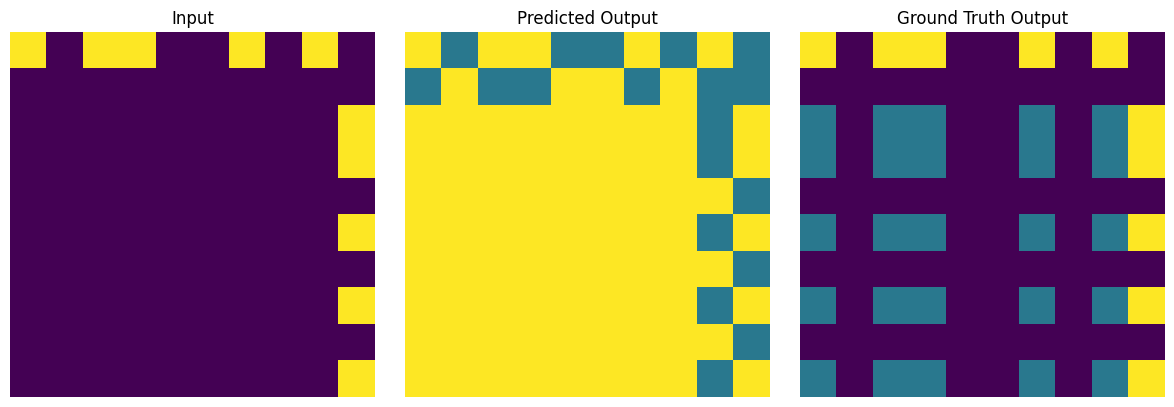

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------- helper --------------------
def safe_transform(grid):
    grid = grid.copy()        # <‑‑ clone so the original stays unchanged
    try:
        return transform(grid)
    except Exception as err:
        print(f"[safe_transform] transform() failed – {err}")
        return np.zeros_like(grid)

# -------------------- test case -----------------
test_case = {
    "input": np.array([  # convert to np.array for convenience
        [5, 0, 5, 5, 0, 0, 5, 0, 5, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]
    ]),
    "output": np.array([
        [5, 0, 5, 5, 0, 0, 5, 0, 5, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5]
    ])
}

# -------------------- run & plot ----------------
predicted_output = safe_transform(test_case["input"])

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
titles = ["Input", "Predicted Output", "Ground Truth Output"]
grids  = [test_case["input"], predicted_output, test_case["output"]]

for ax, grid, title in zip(axs, grids, titles):
    im = ax.imshow(grid, cmap="viridis", vmin=0, vmax=5)
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [58]:
# Inference testing section ends here

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [59]:
# !pip show transformers

In [60]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/chat_template.jinja',
 'lora_model/vocab.json',
 'lora_model/merges.txt',
 'lora_model/added_tokens.json',
 'lora_model/tokenizer.json')

You can use this also to load a checkpoint!!! i.e. an intermediate checkpoint from training, so you can then push it to hub.

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [61]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        # max_seq_length = 30000,
        load_in_4bit = False,
    )

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [62]:
from huggingface_hub import HfFolder, login

# Call this at the top of your script / notebook
if HfFolder.get_token() is None:   # no token cached or in $HF_TOKEN
    login()                        # interactive prompt

In [63]:
# print(model)

In [64]:
# run_name = "Qwen2.5-Coder-7B-Instruct-gemini_synth_50_random_split_1_training-20250723-113848"
print(f"Pushing to Trelis/{run_name}")

Pushing to Trelis/Soar-qwen-7b-ds20250729_114431-20250731-140526


In [65]:
model = model.merge_and_unload()
model.push_to_hub(f"Trelis/{run_name}")
tokenizer.push_to_hub(f"Trelis/{run_name}")

README.md:   0%|          | 0.00/561 [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Saved model to https://huggingface.co/Trelis/Soar-qwen-7b-ds20250729_114431-20250731-140526


README.md:   0%|          | 0.00/567 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

In [66]:
# # Merge to 16bit
# if False:
#     model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
# if True: # Pushing to HF Hub
#     model.push_to_hub_merged(f"Trelis/{run_name}", tokenizer, save_method = "merged_16bit")

# # Merge to 4bit
# if False:
#     model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
# if False: # Pushing to HF Hub
#     model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# # Just LoRA adapters
# if False:
#     model.save_pretrained("model")
#     tokenizer.save_pretrained("model")
# if False: # Pushing to HF Hub
#     model.push_to_hub("hf/model", token = "")
#     tokenizer.push_to_hub("hf/model", token = "")


In [67]:
# print(tokenizer.chat_template)

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

[**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)

In [68]:
# Save to 8bit Q8_0
if False:
    model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False:
    model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False:
    model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: # Pushing to HF Hub
    model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False:
    model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: # Pushing to HF Hub
    model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "", # Get a token at https://huggingface.co/settings/tokens
    )

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in llama.cpp or a UI based system like Jan or Open WebUI. You can install Jan [here](https://github.com/janhq/jan) and Open WebUI [here](https://github.com/open-webui/open-webui)

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
